<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)







```
pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
from torch import autograd  # TO USE "with autograd.detect_anomaly():"
import numpy as np
import matplotlib.pyplot as plt
import math
import random


import os

use_gpu = True

In [2]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
               'Five', 'Six', 'Seven', 'Eight', 'Nine']

In [3]:
def plot_data(file_name, num_images, images, labels=None):

  images = images.cpu()

  images = images.detach().numpy()

  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28), cmap="gray")
      if labels != None:
        plt.xlabel(class_names[labels[i]])      
  plt.savefig(file_name)
  plt.close()

In [4]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        # 32 x 784 x 256
        return torch.sum(log_p, dim)
        # 32 x 784
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [5]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.ReLU(), nn.Linear(H, H//2), nn.ReLU(), nn.Linear(H//2, H//4), nn.ReLU(), nn.Linear(H//4, 2*L))

    def encode(self, x):
      # Flatten the input to a single dimension
      x = torch.flatten(x, start_dim=1)

      mu, log_var = self.forward(x)

      return x, mu, log_var

    def forward(self, x):
      x = x.to(device)

      h = self.encoder_net(x)

      # Split the neural network output for means and log variances
      mu, log_var =  torch.chunk(h, 2, dim=1)
      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std
      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)

In [6]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H//4), nn.ReLU(), nn.Linear(H//4, H//2), nn.ReLU(), nn.Linear(H//2, H), nn.ReLU(), nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

    def sample(self, z):
        x_generated = self.decode(z)

        if self.distribution == 'categorical':
            b = x_generated.shape[0]
            m = x_generated.shape[1]
            x_generated = x_generated.view(b, -1, self.num_vals)
            p = x_generated.view(-1, self.num_vals)
            x_generated = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            x_generated = torch.bernoulli(x_generated)

        return x_generated

    

In [7]:
class Prior(nn.Module):
    def __init__(self, L, prior_distribution):
        super(Prior, self).__init__()
        self.L = L
        self.distribution = prior_distribution

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
      if (self.distribution == 'standard normal'):
        return log_standard_normal(z)

      # elif self.distribution == ''
        # return log____(z)

In [8]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior_distribution):
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = Prior(L, prior_distribution)


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        
        x, mu, log_var = self.encoder.encode(x)

        # Sample z based on the mean and log variance
        z = self.encoder.sample(mu, log_var)

        # Decode the latent representation and reconstruct input
        x_new = self.decoder.decode(z)

        # Reconstructed images based on the highest probability assigned for each pixel
        if (self.distribution == 'categorical'):
          x_reconstructed, idx = torch.max(x_new, dim=2)
        else:
          x_reconstructed = x_new

        # Evidence Lower Bound
        ELBO = self.loss(x, x_new, z, mu, log_var, reduction)

        return x_reconstructed, ELBO
  
  def loss(self, x, x_new, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, x_new)

    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)

    if reduction == 'sum':
      # For testing sum all the loss values in the batch then take the average in the training loop
      return -(RE + KL).sum() 
    else:
      # For training calculate the mean of the loss values of the batch
      return -(RE + KL).mean()


  def log_prob(self, x, x_new):

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)  # (32)

    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob

  def sample(self, batch_size=128):
    z = self.prior.sample(batch_size=batch_size)

    z = z.to(device)  # FOR GENERATING SAMPLES

    return self.decoder.sample(z)

In [9]:
import math
import numbers
import warnings
from enum import Enum

from PIL import Image

from torch import Tensor
from typing import List, Tuple, Any, Optional

try:
    import accimage
except ImportError:
    accimage = None

https://github.com/pytorch/vision/blob/a839796328cf4f789c9de5da0b3367b742b5a00c/torchvision/transforms/transforms.py

In [10]:
# CUSTOM TRANFORM FOR THE DATA WITHOUT NORMALIZING

class ToTensor:
    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(np.array(pic))

    def __repr__(self):
        return self.__class__.__name__ + '()'

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.
    See :class:`~torchvision.transforms.ToTensor` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype)
    else:
        return img

MNIST FROM: http://yann.lecun.com/exdb/mnist/

In [11]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([ToTensor()])

batch_size = 64

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\Pelinsu\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
# DISTRUBUTION FOR THE INPUT DATA
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1

prior_distribution = 'standard normal'

In [13]:
D = 28*28 # INPUT DATA DIMENSIONALITY
H = 512   # HIDDEN LAYER NODES
L = 2    # LATENT VARIABLES DIMENSIONALITY

learning_rate = 0.001
num_epochs = 100

In [14]:
model = VAE(D, H, L, likelihood_type, num_vals, prior_distribution)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

# ADAM OPTIMIZER
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr=learning_rate)

In [15]:
results_dir = 'Results/'
if not(os.path.exists(results_dir)):
    os.mkdir(results_dir)

model_name = 'VAE'

In [16]:
def generate_samples(name, extra_name, num_samples):
  
  model_best = torch.load(name + '.model')

  model_best = model_best.to(device)

  model_best.eval()

  x = torch.tensor(0, device=device)

  x = model_best.sample(num_samples)

  x = x.cpu()

  plot_data(name + '_Generated_images' + extra_name, num_samples, x)  

In [19]:
train_loss_avgs = []
best_loss = 1000.

num_samples = 16

print("Training...")

name = results_dir + model_name

for epoch in range(num_epochs):
  model.train()

  train_loss_avgs.append(0)
  num_batches = 0
  for batch_idx, (data, labels) in enumerate(train_dataloader, 1):

    #with autograd.detect_anomaly():
      
    data = data.to(device)    
    x_reconstructed, loss = model.forward(data)   

    optimizer.zero_grad()
    loss.backward(retain_graph=True)    
    optimizer.step()    
    train_loss_avgs[-1] += loss.item()
    num_batches += 1

    if batch_idx == random.randint(0, len(train_dataloader)):
      plot_data(name + "_Reconstructed_images_epoch_" + str(epoch+1) + "_batch_" + str(batch_idx), num_samples, x_reconstructed, labels)   

  train_loss_avgs[-1] /= num_batches
  print('Epoch [%d / %d] average training loss: %f' % (epoch+1, num_epochs, train_loss_avgs[-1]))

  if epoch == 0:
    print('Model Saved!')
    torch.save(model, name + '.model')
    best_loss = train_loss_avgs[-1]

  else:
    if train_loss_avgs[-1] < best_loss:
      print('Model Saved!')
      torch.save(model, name + '.model')
      best_loss = train_loss_avgs[-1]

      generate_samples(name, "_epoch_" + str(epoch+1), num_samples)


Training...
Epoch [1 / 100] average training loss: 880.860554
Model Saved!


KeyboardInterrupt: ignored

In [20]:
model_best = torch.load(name + '.model')

# set to evaluation mode
model.eval()

test_loss, num_batches = 0, 0

for batch_idx, (data, labels) in enumerate(test_dataloader, 1):
    
  data = data.to(device)  

  x_reconstructed, loss = model.forward(data, reduction='sum')

  if batch_idx == 2:
    plot_data(name + "_Reconstructed_images_test_data_batch" + str(batch_idx+1), 16, x_reconstructed, labels)
    generate_samples(name, "_test_data_batch_" + str(batch_idx))

  test_loss += loss.item()
  num_batches = num_batches + data.shape[0]
    
test_loss /= num_batches
print('Average test loss: %f' % (test_loss))

Average test loss: 847.179825


In [21]:
batch_num = 522

for batch_idx, (data, labels) in enumerate(train_dataloader, 1):
  
  data = data.to(device)

  if batch_idx == batch_num:
      plot_data(name + "_Real_images_train_data" + "_batch_" + str(batch_idx), 16, data, labels)

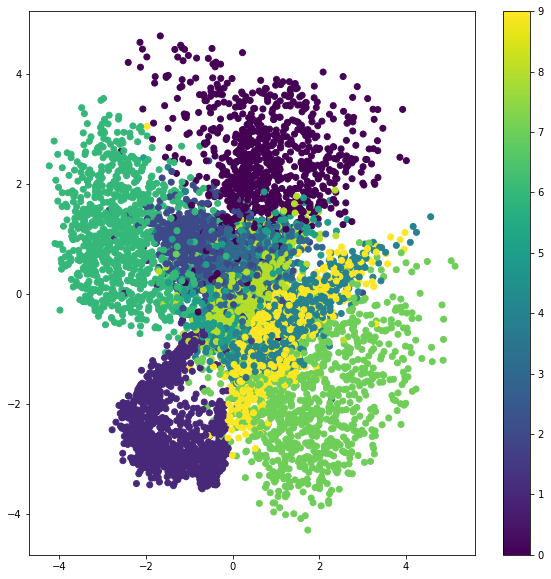

In [22]:
#imgs, labels = next(iter(test_dataloader))
plt.figure(figsize=(10, 10))

for imgs, labels in test_dataloader:
  img = imgs.to(device)
  x, x_encoded_mean, x_encoded_log_var = model.encoder.encode(imgs)


  x_encoded_mean = x_encoded_mean.cpu().detach().numpy()

  plt.scatter(x_encoded_mean[:, 0], x_encoded_mean[:, 1], c=labels)

plt.colorbar()
plt.savefig("encoding.png")

In [23]:
# REAL SAMPLES
num_samples = 16

test_data, test_labels = next(iter(test_dataloader))

plot_data(name + 'Real_images_test_data_', num_samples, test_data, test_labels)

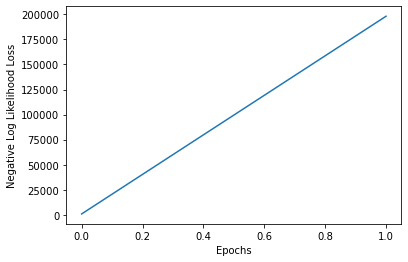

[880.8605537333214, 198119.80792236328]


In [24]:
# plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs)
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

print(train_loss_avgs)

In [34]:
f = open(name + '_Model_Description.txt', "w")

f.write("VAE \n---------------------------------\n"
        "Dataset:\n" + str(train_dataset)+ "\n"+
        "- Batch Size: "+ str(batch_size) + "\n"+
        "- Likelihood: "+ likelihood_type + "\n"+
        "- Prior Distribution: "+ prior_distribution + "\n"
        "- Number of Values: "+ str(num_vals) + "\n"+
        "- Number of Latents: " + str(L) + "\n\n"+
        "Model:\n" + str(model) + "\n\n"+
        "Optimizer:\n"+ str(optimizer) + "\n"+
        "- Number of Epochs: "+ str(num_epochs) + "\n\n"+
        "Results:\n-------------------------------\n"
        "- Average Training Loss: " + str(train_loss_avgs[-1]) + "\n"+
        "- Average Test Loss: " + str(test_loss))
f.close()